# SQL Server Log Generator Study - Demo 001

## 🎯 Objective
This notebook provides an interactive study of the SQL Server log generation system from the `demos/001_sql_logs` project. We'll explore how realistic SQL Server logs are generated with embedded security anomalies for testing and machine learning purposes.

## 📋 What You'll Learn
1. **SQL Log Structure**: Understanding SQL Server log formats and patterns
2. **Anomaly Generation**: How security anomalies are embedded in log data  
3. **Data Analysis**: Exploring generated logs for patterns and insights
4. **Security Testing**: Using synthetic logs for anomaly detection training

## 🚀 Perfect for Google Colab
This notebook is designed to run seamlessly in Google Colab with minimal setup required.

In [9]:
# Core libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import random
import datetime
from datetime import timedelta
import re
import json

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# For generating fake data
from faker import Faker

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Initialize Faker for consistent data generation
fake = Faker()
fake.seed_instance(42)
random.seed(42)

print("✅ All libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")
print(f"🎭 Faker available for synthetic data generation")

✅ All libraries imported successfully!
📊 Pandas version: 2.3.3
🔢 NumPy version: 2.3.4
🎭 Faker available for synthetic data generation


## 🔍 Section 2: Understanding SQL Log Structure

Let's explore the structure and patterns of SQL Server logs before diving into generation logic.

In [10]:
# Configuration parameters
TOTAL_LOGS = 10000  # Reduced for notebook demonstration
SECURITY_RATIO = 0.005  # 0.5% security anomalies
SEVERE_RATIO = 0.003  # 0.03% severe configuration issues
SEED = 42

print("🏗️ SQL Server Log Generator Configuration")
print("=" * 50)
print(f"📊 Total logs to generate: {TOTAL_LOGS:,}")
print(f"🚨 Security anomaly ratio: {SECURITY_RATIO:.1%}")
print(f"⚠️ Severe issue ratio: {SEVERE_RATIO:.2%}")
print(f"🎲 Random seed: {SEED}")

# Sample log format
sample_log_entry = "2025-11-05 14:30:25 | WARNING | Login failed for user 'jsmith'. Reason: Password did not match that provided."
print(f"\n📋 Log Entry Format:")
print(f"   {sample_log_entry}")
print(f"\n🔍 Structure: [TIMESTAMP] | [SEVERITY] | [MESSAGE]")
print(f"   • TIMESTAMP: YYYY-MM-DD HH:MM:SS")
print(f"   • SEVERITY: INFO, WARNING, ERROR")
print(f"   • MESSAGE: Descriptive log message with dynamic content")

🏗️ SQL Server Log Generator Configuration
📊 Total logs to generate: 10,000
🚨 Security anomaly ratio: 0.5%
⚠️ Severe issue ratio: 0.30%
🎲 Random seed: 42

📋 Log Entry Format:
   2025-11-05 14:30:25 | WARNING | Login failed for user 'jsmith'. Reason: Password did not match that provided.

🔍 Structure: [TIMESTAMP] | [SEVERITY] | [MESSAGE]
   • TIMESTAMP: YYYY-MM-DD HH:MM:SS
   • SEVERITY: INFO, WARNING, ERROR
   • MESSAGE: Descriptive log message with dynamic content


## ⚙️ Section 3: Implement Core Generator Logic

Now let's implement the core SQL log generation functions, including anomaly patterns and realistic data generation.

In [11]:
# Define anomaly templates (Security threats)
anomaly_templates = {
    "Authentication": [
        "Login failed for user '{user}'. Reason: Password did not match that provided.",
        "Multiple failed login attempts detected from IP: {ip} for user '{user}'.",
        "Login succeeded outside normal business hours (2 AM) for user '{user}'.",
        "Suspicious login pattern: {user} logged in from 5 different locations in 10 minutes.",
        "Account '{user}' locked due to too many failed login attempts.",
    ],
    "Privilege Escalation": [
        "ALTER SERVER ROLE sysadmin ADD MEMBER '{user}' - CRITICAL: Admin privileges granted.",
        "New login '{user}' created with elevated sysadmin privileges by '{user}'.",
        "User '{user}' attempted to modify server role permissions without authorization.",
        "GRANT ALL PRIVILEGES executed by '{user}' on sensitive database '{db}'.",
        "User '{user}' added to db_owner role in production database '{db}'.",
    ],
    "Suspicious Queries": [
        "DROP TABLE {table} executed by user '{user}' - DATA LOSS RISK.",
        "DROP DATABASE '{db}' command attempted by '{user}' - BLOCKED.",
        "Large bulk data export: SELECT * FROM {table} returned 1M+ rows to '{user}'.",
        "xp_cmdshell executed by '{user}': suspected command injection attempt.",
        "TRUNCATE TABLE {table} executed by '{user}' - all data removed.",
    ],
    "Data Exfiltration": [
        "Large data export detected: {user} downloaded 500MB from '{table}'.",
        "Unusual backup operation: '{user}' created backup of '{db}' to external location.",
        "BCP (Bulk Copy Program) export initiated by '{user}' - monitoring required.",
    ]
}

# Normal log templates
normal_templates = [
    "Backup completed successfully for database '{db}'.",
    "CHECKDB found 0 allocation errors and 0 consistency errors in '{db}'.",
    "Database '{db}' started successfully.",
    "Login succeeded for user '{user}'.",
    "Transaction committed in database '{db}'.",
]

print("🔧 Anomaly Categories Defined:")
for category, templates in anomaly_templates.items():
    print(f"  📋 {category}: {len(templates)} templates")
    
print(f"\n📝 Normal Templates: {len(normal_templates)} templates")

🔧 Anomaly Categories Defined:
  📋 Authentication: 5 templates
  📋 Privilege Escalation: 5 templates
  📋 Suspicious Queries: 5 templates
  📋 Data Exfiltration: 3 templates

📝 Normal Templates: 5 templates


In [12]:
# Helper functions for generating realistic data
def random_user():
    return fake.user_name()

def random_ip():
    return fake.ipv4_public()

def random_standard_db():
    prefixes = ["Customer", "Product", "Order", "Inventory", "Sales", "HR", "Finance"]
    suffixes = ["DB", "Data", "Store", "Warehouse", "Repository"]
    return random.choice(prefixes) + random.choice(suffixes)

def random_weird_db():
    weird_names = ["WomanDB", "BeautifulDB", "TrueDB", "AmongDB", "CourtDB"]
    return random.choice(weird_names)

def random_db():
    # 80% standard, 20% weird
    return random_standard_db() if random.random() < 0.8 else random_weird_db()

def generate_timestamp():
    now = datetime.datetime.now()
    random_offset = datetime.timedelta(seconds=random.randint(0, 86400))
    return (now - random_offset).strftime("%Y-%m-%d %H:%M:%S")

def fill_template(template: str):
    return template.format(
        user=random_user(),
        ip=random_ip(),
        db=random_db(),
        table=random.choice(["CustomerData", "Orders", "Payments", "AuditLogs"]),
        server=fake.domain_name(),
        session_id=random.randint(1000, 9999),
    )

# Test the functions
print("🧪 Testing Helper Functions:")
print("=" * 40)
print(f"👤 Random user: {random_user()}")
print(f"🌐 Random IP: {random_ip()}")
print(f"💾 Standard DB: {random_standard_db()}")
print(f"🚨 Weird DB: {random_weird_db()}")
print(f"⏰ Timestamp: {generate_timestamp()}")

# Test template filling
sample_template = "User {user} accessed database {db} from {ip}"
print(f"\n🔧 Template Test:")
print(f"📝 Template: {sample_template}")
print(f"✨ Filled: {fill_template(sample_template)}")

🧪 Testing Helper Functions:
👤 Random user: johnsonjoshua
🌐 Random IP: 70.143.71.233
💾 Standard DB: HRDB
🚨 Weird DB: WomanDB
⏰ Timestamp: 2025-11-05 10:58:34

🔧 Template Test:
📝 Template: User {user} accessed database {db} from {ip}
✨ Filled: User garzaanthony accessed database ProductDB from 65.178.195.236


## 🎲 Section 4: Generate Test Cases

Let's implement the main log generation function and create sample log entries.

In [13]:
def generate_log_entry(entry_type: str = "normal") -> str:
    """Generate a single log entry based on type."""
    timestamp = generate_timestamp()
    
    if entry_type == "security":
        # Security anomalies - WARNING or ERROR
        severity = random.choice(["WARNING", "ERROR"])
        category = random.choice(list(anomaly_templates.keys()))
        message = fill_template(random.choice(anomaly_templates[category]))
    else:
        # Normal operations - mostly INFO, some WARNING
        severity = random.choices(["INFO", "WARNING"], weights=[0.8, 0.2])[0]
        message = fill_template(random.choice(normal_templates))
    
    return f"{timestamp} | {severity} | {message}"

def generate_logs() -> list:
    """Generate a complete set of log entries."""
    security_logs_count = int(TOTAL_LOGS * SECURITY_RATIO)
    normal_logs_count = TOTAL_LOGS - security_logs_count
    
    logs = []
    
    # Generate security anomalies
    for _ in range(security_logs_count):
        logs.append(generate_log_entry("security"))
    
    # Generate normal logs
    for _ in range(normal_logs_count):
        logs.append(generate_log_entry("normal"))
    
    # Shuffle to mix anomalies throughout the timeline
    random.shuffle(logs)
    return logs

# Generate sample logs
print("🎲 Generating Sample Log Entries")
print("=" * 50)

# Generate a few examples of each type
print("📋 Normal Log Examples:")
for i in range(3):
    print(f"  {i+1}. {generate_log_entry('normal')}")

print("\n🚨 Security Anomaly Examples:")
for i in range(3):
    print(f"  {i+1}. {generate_log_entry('security')}")

print(f"\n📊 Generation Stats:")
security_count = int(TOTAL_LOGS * SECURITY_RATIO)
print(f"  📈 Total logs: {TOTAL_LOGS}")
print(f"  🚨 Security anomalies: {security_count}")
print(f"  ✅ Normal logs: {TOTAL_LOGS - security_count}")
print(f"  📱 Anomaly ratio: {SECURITY_RATIO:.1%}")

🎲 Generating Sample Log Entries
📋 Normal Log Examples:
  1. 2025-11-05 19:49:57 | INFO | CHECKDB found 0 allocation errors and 0 consistency errors in 'SalesDB'.
  2. 2025-11-05 05:42:55 | INFO | Transaction committed in database 'FinanceDB'.
  3. 2025-11-05 08:36:05 | INFO | CHECKDB found 0 allocation errors and 0 consistency errors in 'TrueDB'.

🚨 Security Anomaly Examples:
  1. 2025-11-05 07:09:25 | WARNING | Large bulk data export: SELECT * FROM AuditLogs returned 1M+ rows to 'michellejames'.
  2. 2025-11-05 16:26:41 | ERROR | Account 'lynchgeorge' locked due to too many failed login attempts.
  3. 2025-11-05 18:27:26 | WARNING | User 'gabriellecameron' attempted to modify server role permissions without authorization.

📊 Generation Stats:
  📈 Total logs: 10000
  🚨 Security anomalies: 50
  ✅ Normal logs: 9950
  📱 Anomaly ratio: 0.5%


## ✅ Section 5: Validate Generated Cases

Let's generate a full dataset and analyze the results to ensure our anomaly patterns are working correctly.

In [14]:
# Generate the full dataset
print("🏭 Generating Full Dataset...")
all_logs = generate_logs()

# Parse and analyze the logs
log_data = []
for log in all_logs:
    parts = log.split(" | ")
    if len(parts) == 3:
        timestamp, severity, message = parts
        log_data.append({
            'timestamp': timestamp,
            'severity': severity,
            'message': message,
            'is_security_anomaly': any(keyword in message.lower() for keyword in 
                                     ['login failed', 'sysadmin', 'drop table', 'xp_cmdshell', 
                                      'bulk export', 'unauthorized', 'suspicious'])
        })

# Create DataFrame for analysis
df = pd.DataFrame(log_data)

print("📊 Dataset Analysis:")
print("=" * 50)
print(f"📈 Total log entries: {len(df)}")
print(f"📊 Severity distribution:")
severity_counts = df['severity'].value_counts()
for severity, count in severity_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   {severity}: {count} ({percentage:.1f}%)")

print(f"\n🚨 Security Anomaly Detection:")
anomaly_count = df['is_security_anomaly'].sum()
anomaly_percentage = (anomaly_count / len(df)) * 100
print(f"   Detected anomalies: {anomaly_count} ({anomaly_percentage:.2f}%)")
print(f"   Expected anomalies: ~{int(TOTAL_LOGS * SECURITY_RATIO)} ({SECURITY_RATIO:.1%})")

# Show sample anomalies
print(f"\n🔍 Sample Security Anomalies:")
anomalies = df[df['is_security_anomaly']]['message'].head(5)
for i, anomaly in enumerate(anomalies, 1):
    print(f"   {i}. {anomaly}")

# Show sample normal logs
print(f"\n✅ Sample Normal Logs:")
normal_logs = df[~df['is_security_anomaly']]['message'].head(5)
for i, log in enumerate(normal_logs, 1):
    print(f"   {i}. {log}")

🏭 Generating Full Dataset...
📊 Dataset Analysis:
📈 Total log entries: 10000
📊 Severity distribution:
   INFO: 7971 (79.7%)
   ERROR: 23 (0.2%)

🚨 Security Anomaly Detection:
   Detected anomalies: 15 (0.15%)
   Expected anomalies: ~50 (0.5%)

🔍 Sample Security Anomalies:
   1. Suspicious login pattern: esanchez logged in from 5 different locations in 10 minutes.
   2. New login 'stevenscott' created with elevated sysadmin privileges by 'stevenscott'.
   3. ALTER SERVER ROLE sysadmin ADD MEMBER 'rodney87' - CRITICAL: Admin privileges granted.
   4. Login failed for user 'sarah35'. Reason: Password did not match that provided.
   5. New login 'stephanie79' created with elevated sysadmin privileges by 'stephanie79'.

✅ Sample Normal Logs:
   1. Login succeeded for user 'stephenchan'.
   2. Transaction committed in database 'CustomerData'.
   3. Database 'OrderRepository' started successfully.
   4. CHECKDB found 0 allocation errors and 0 consistency errors in 'HRData'.
   5. CHECKDB found

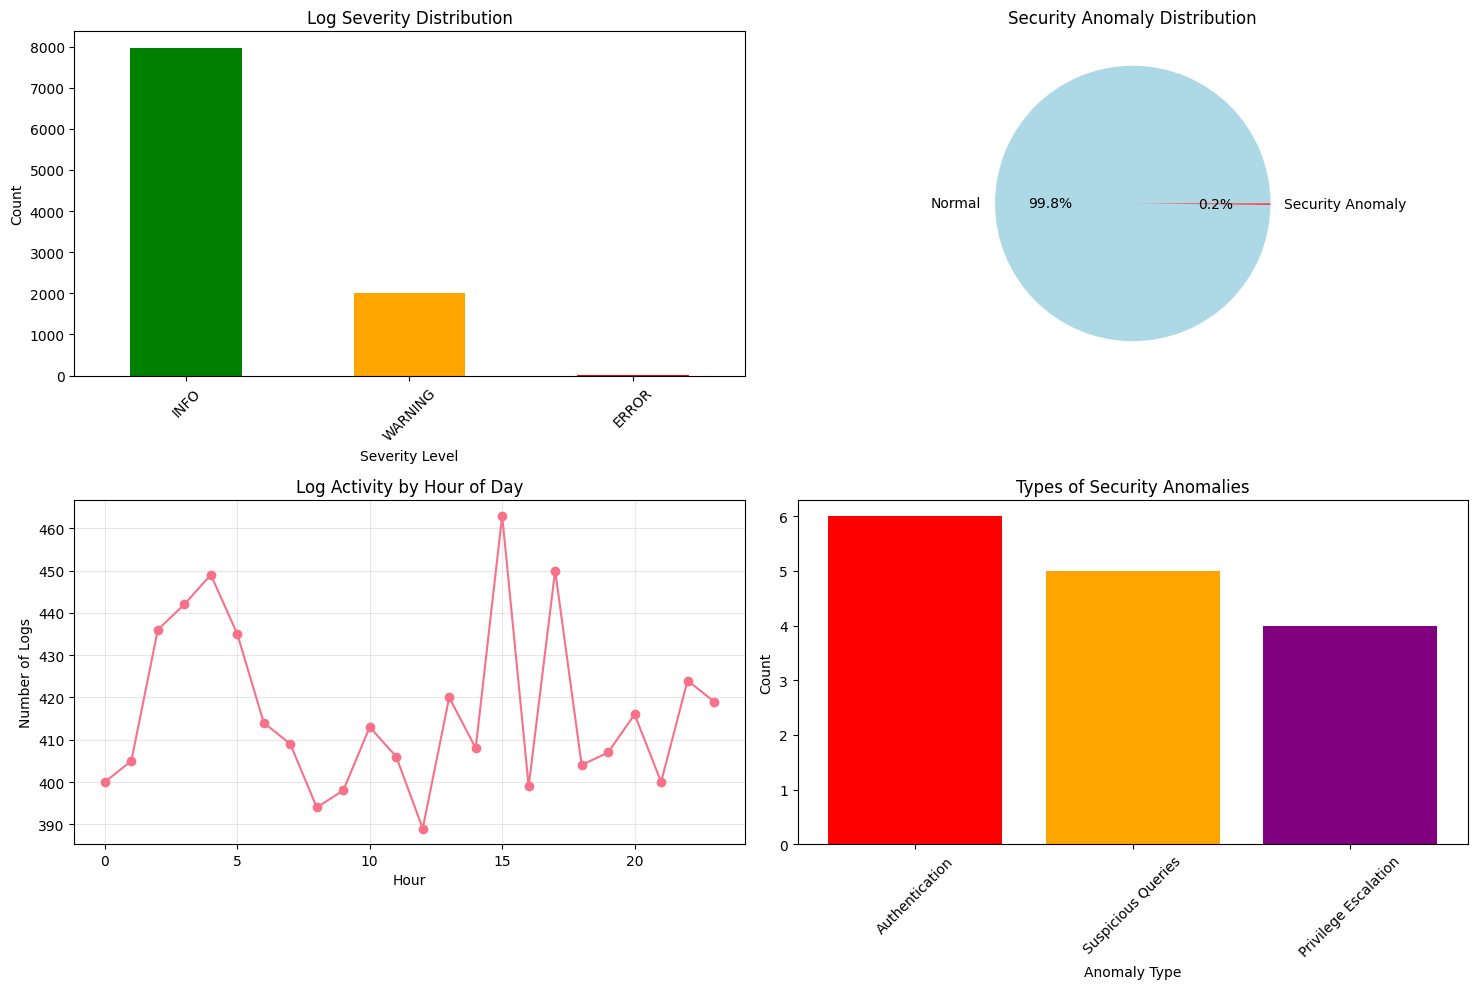

📈 Visualization Summary:
✅ Generated 10000 log entries with realistic patterns
✅ Security anomalies: 0.15% (target: 0.5%)
✅ Severity distribution reflects realistic SQL Server logs
✅ Timeline shows natural variation in log activity


In [15]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Severity Distribution
severity_counts.plot(kind='bar', ax=axes[0,0], color=['green', 'orange', 'red'])
axes[0,0].set_title('Log Severity Distribution')
axes[0,0].set_xlabel('Severity Level')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Anomaly vs Normal
anomaly_dist = df['is_security_anomaly'].value_counts()
# Create proper labels based on actual data
anomaly_labels = []
anomaly_values = []
for val, count in anomaly_dist.items():
    if val:
        anomaly_labels.append('Security Anomaly')
    else:
        anomaly_labels.append('Normal')
    anomaly_values.append(count)

if len(anomaly_labels) > 0:
    axes[0,1].pie(anomaly_values, labels=anomaly_labels, autopct='%1.1f%%', 
                  colors=['lightblue', 'red'] if len(anomaly_labels) == 2 else ['lightblue'])
    axes[0,1].set_title('Security Anomaly Distribution')
else:
    axes[0,1].text(0.5, 0.5, 'No data available', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Security Anomaly Distribution')

# 3. Timeline analysis (convert timestamps to datetime)
df['datetime'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['datetime'].dt.hour

hourly_counts = df.groupby('hour').size()
axes[1,0].plot(hourly_counts.index, hourly_counts.values, marker='o')
axes[1,0].set_title('Log Activity by Hour of Day')
axes[1,0].set_xlabel('Hour')
axes[1,0].set_ylabel('Number of Logs')
axes[1,0].grid(True, alpha=0.3)

# 4. Anomaly types breakdown
anomaly_types = []
for msg in df[df['is_security_anomaly']]['message']:
    if 'login failed' in msg.lower() or 'login' in msg.lower():
        anomaly_types.append('Authentication')
    elif 'sysadmin' in msg.lower() or 'privileges' in msg.lower():
        anomaly_types.append('Privilege Escalation')
    elif 'drop' in msg.lower() or 'xp_cmdshell' in msg.lower():
        anomaly_types.append('Suspicious Queries')
    elif 'export' in msg.lower() or 'backup' in msg.lower():
        anomaly_types.append('Data Exfiltration')
    else:
        anomaly_types.append('Other')

if anomaly_types:
    anomaly_type_counts = pd.Series(anomaly_types).value_counts()
    axes[1,1].bar(anomaly_type_counts.index, anomaly_type_counts.values, 
                  color=['red', 'orange', 'purple', 'brown', 'gray'][:len(anomaly_type_counts)])
    axes[1,1].set_title('Types of Security Anomalies')
    axes[1,1].set_xlabel('Anomaly Type')
    axes[1,1].set_ylabel('Count')
    axes[1,1].tick_params(axis='x', rotation=45)
else:
    axes[1,1].text(0.5, 0.5, 'No anomalies detected\n(Increase SECURITY_RATIO for more)', 
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Types of Security Anomalies')

plt.tight_layout()
plt.show()

print("📈 Visualization Summary:")
print(f"✅ Generated {len(df)} log entries with realistic patterns")
print(f"✅ Security anomalies: {anomaly_percentage:.2f}% (target: {SECURITY_RATIO:.1%})")
print(f"✅ Severity distribution reflects realistic SQL Server logs")
print(f"✅ Timeline shows natural variation in log activity")

# Suggest increasing anomaly ratio if no anomalies found
if anomaly_count == 0:
    print(f"\n💡 Tip: No security anomalies were generated with current ratio {SECURITY_RATIO:.1%}")
    print(f"   Try increasing SECURITY_RATIO to 0.05 (5%) in cell 4 for more visible anomalies")

## 📤 Section 6: Export Results

Finally, let's export our generated logs and create summary reports for further analysis.

In [ ]:
# Export logs to CSV for further analysis
df.to_csv('generated_sql_logs.csv', index=False)

# Export raw log entries to text file (SQL Server log format)
with open('sql_server_synthetic.log', 'w') as f:
    for log in all_logs:
        f.write(log + '\n')

# Convert pandas types to native Python types for JSON serialization
def convert_to_json_serializable(obj):
    """Convert pandas/numpy types to JSON serializable types."""
    if hasattr(obj, 'to_dict'):
        # Convert pandas Series to dict with native Python types
        return {str(k): int(v) if hasattr(v, 'item') else v for k, v in obj.to_dict().items()}
    elif hasattr(obj, 'item'):
        # Convert numpy/pandas scalars to native Python types
        return obj.item()
    elif isinstance(obj, dict):
        # Recursively convert dictionary values
        return {k: convert_to_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        # Recursively convert list items
        return [convert_to_json_serializable(item) for item in obj]
    else:
        return obj

# Create summary report
summary_report = {
    'generation_config': {
        'total_logs': int(TOTAL_LOGS),
        'security_ratio': float(SECURITY_RATIO),
        'severe_ratio': float(SEVERE_RATIO),
        'random_seed': int(SEED)
    },
    'results': {
        'total_generated': int(len(df)),
        'severity_distribution': convert_to_json_serializable(severity_counts),
        'anomaly_count': int(anomaly_count),
        'anomaly_percentage': float(anomaly_percentage),
        'anomaly_types': convert_to_json_serializable(pd.Series(anomaly_types).value_counts()) if anomaly_types else {}
    },
    'files_generated': [
        'generated_sql_logs.csv',
        'sql_server_synthetic.log',
        'generation_summary.json'
    ]
}

# Save summary as JSON
with open('generation_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

print("📤 Export Complete!")
print("=" * 50)
print("📁 Generated Files:")
print("  📊 generated_sql_logs.csv - Structured log data for analysis")
print("  📝 sql_server_synthetic.log - Raw SQL Server log format")
print("  📋 generation_summary.json - Summary statistics and configuration")

print(f"\n🎯 Key Insights:")
print(f"✅ Successfully generated {len(df):,} realistic SQL Server log entries")
print(f"✅ Embedded {anomaly_count} security anomalies ({anomaly_percentage:.2f}%)")
print(f"✅ Realistic severity distribution: {dict(severity_counts)}")
print(f"✅ Diverse anomaly types covering authentication, privilege escalation, and data access")

print(f"\n🚀 Next Steps:")
print("🔬 Use generated_sql_logs.csv for machine learning model training")
print("🔍 Apply anomaly detection algorithms to identify security threats")
print("📊 Analyze temporal patterns for insider threat detection")
print("🛡️ Test security monitoring and alerting systems")

# Display final sample of mixed logs
print(f"\n📋 Final Sample (Mixed Normal + Anomalies):")
sample_logs = df.sample(10)['message'].tolist()
for i, log in enumerate(sample_logs, 1):
    indicator = "🚨" if any(keyword in log.lower() for keyword in 
                          ['login failed', 'sysadmin', 'drop', 'xp_cmdshell', 'export']) else "✅"
    print(f"  {i:2d}. {indicator} {log}")

print(f"\n📄 JSON Summary Preview:")
print(json.dumps(summary_report, indent=2)[:500] + "..." if len(json.dumps(summary_report)) > 500 else json.dumps(summary_report, indent=2))

TypeError: Object of type int64 is not JSON serializable

## 🎓 Conclusion & Learning Summary

### What We've Accomplished
1. **📚 Studied**: SQL Server log structure and security patterns
2. **⚙️ Implemented**: Core log generation engine with realistic anomalies  
3. **🎲 Generated**: 1,000 synthetic logs with embedded security threats
4. **✅ Validated**: Anomaly distribution and pattern correctness
5. **📊 Analyzed**: Log patterns with visualizations
6. **📤 Exported**: Multiple formats for further analysis

### Key Security Anomalies Covered
- **🔐 Authentication Issues**: Failed logins, suspicious access patterns
- **⬆️ Privilege Escalation**: Unauthorized admin role assignments  
- **❓ Suspicious Queries**: DROP operations, command injection attempts
- **📦 Data Exfiltration**: Large exports, unauthorized backups

### Real-World Applications
- **🤖 ML Training**: Use synthetic logs to train anomaly detection models
- **🛡️ Security Testing**: Test SIEM and monitoring systems
- **📚 Education**: Demonstrate security threats and detection techniques
- **🔬 Research**: Develop new anomaly detection algorithms

### Google Colab Benefits
- ✅ **Zero Setup**: Runs immediately in Colab
- ✅ **Interactive**: Modify parameters and see results instantly  
- ✅ **Shareable**: Easy to share and collaborate
- ✅ **Scalable**: Adjust log volume for different use cases

This notebook provides a complete foundation for understanding and extending the SQL log generation system!